<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/mit_bih_arrhythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIT-BIH Arrhyhmia dataset
In this example, we will use MIT-BIH Arrhythmia dataset.

## Download <code>MIT-BIH Arrhyhmia</code> dataset

In [1]:
# If you run this code on google colab, please use this code instead of the below one.
!wget https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip mit-bih-arrhythmia-database-1.0.0.zip

--2024-12-30 21:39:43--  https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77030320 (73M) [application/zip]
Saving to: ‘mit-bih-arrhythmia-database-1.0.0.zip’

mit-bih-arrhythmia- 100%[===================>]  73.46M   605KB/s    in 2m 13s  

2024-12-30 21:41:57 (568 KB/s) - ‘mit-bih-arrhythmia-database-1.0.0.zip’ saved [77030320/77030320]

Archive:  mit-bih-arrhythmia-database-1.0.0.zip
  inflating: mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mit-bih-a

## Install <code>wfdb</code> library to read WFDB format

In [2]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 12.6 MB/s eta 0:00:00


## Visualization

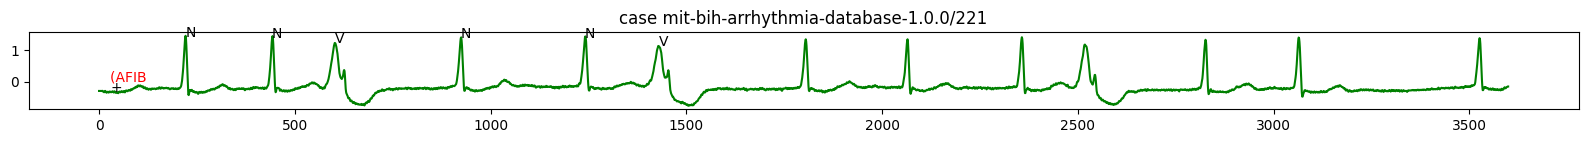

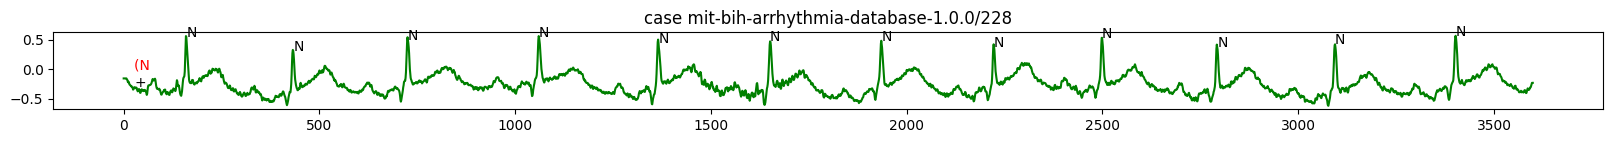

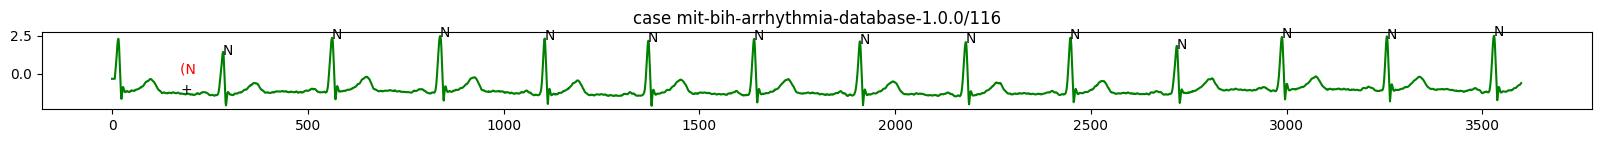

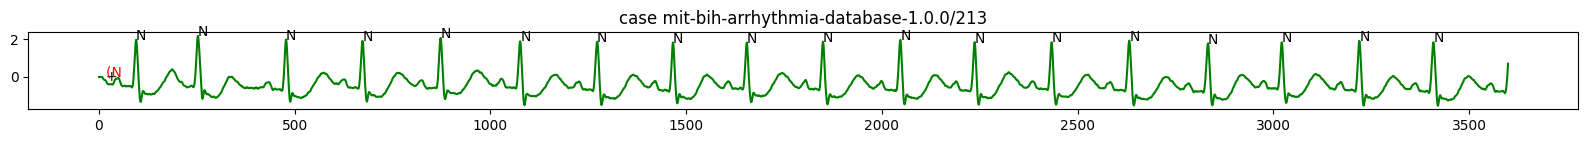

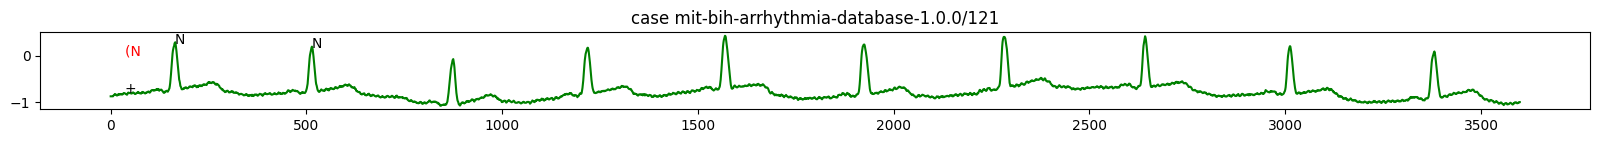

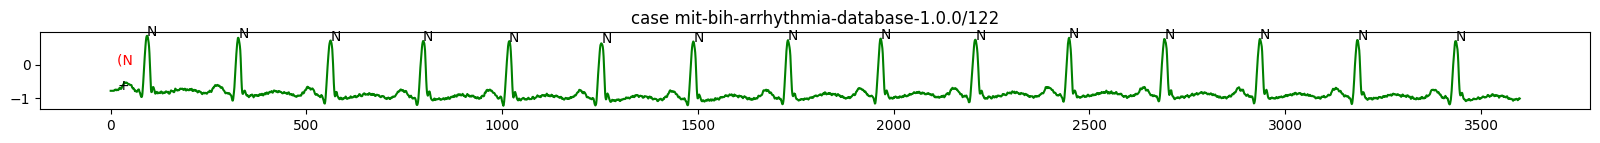

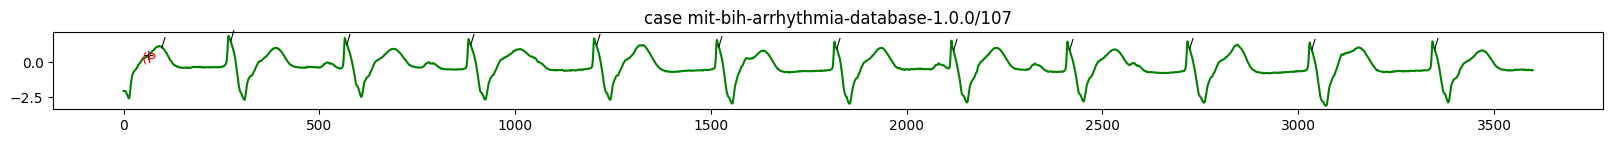

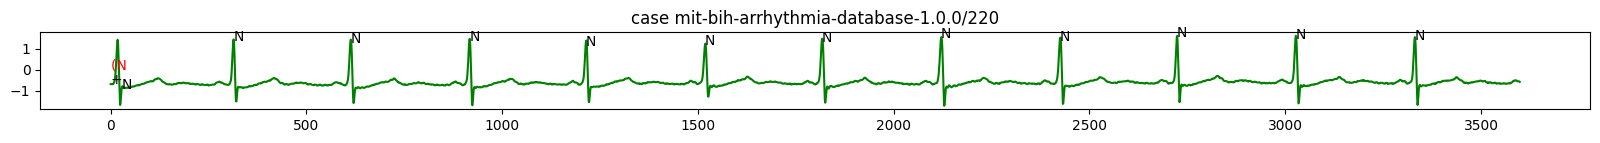

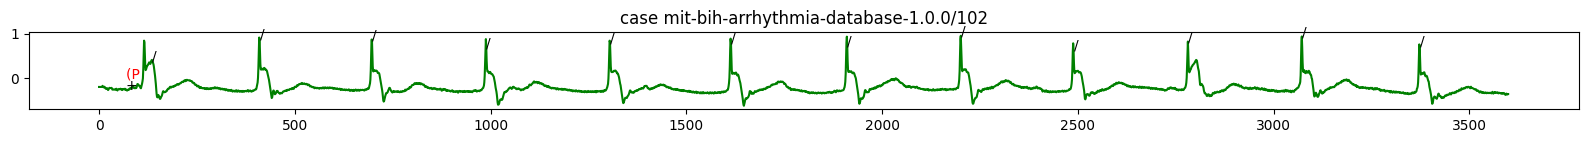

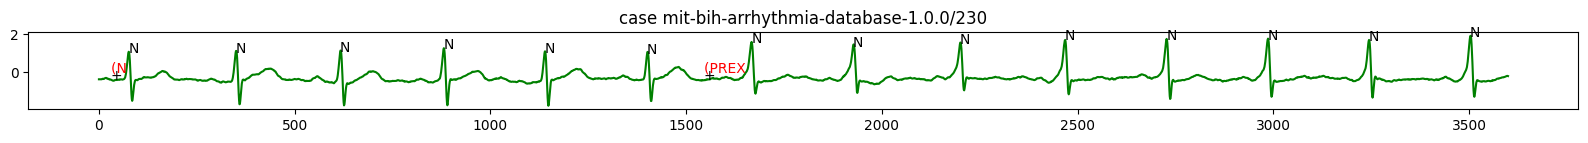

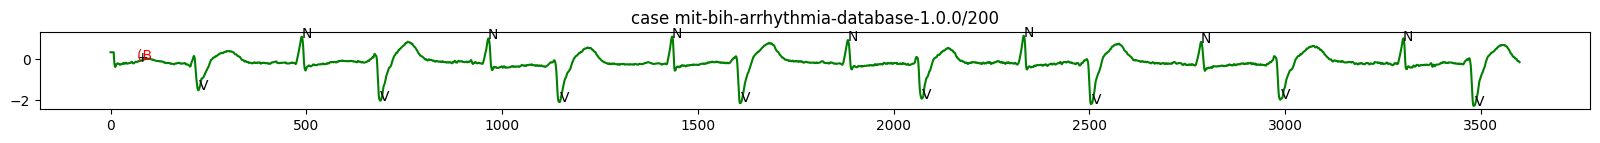

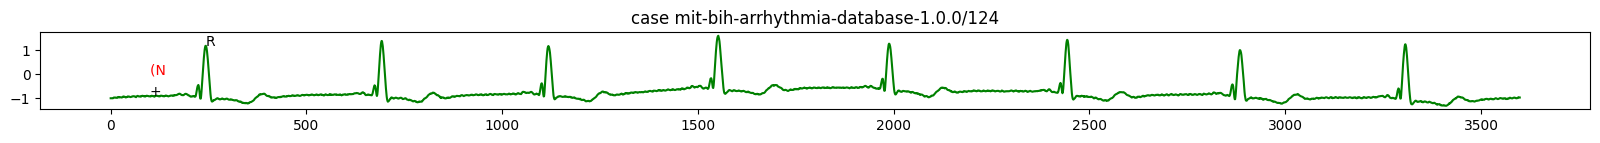

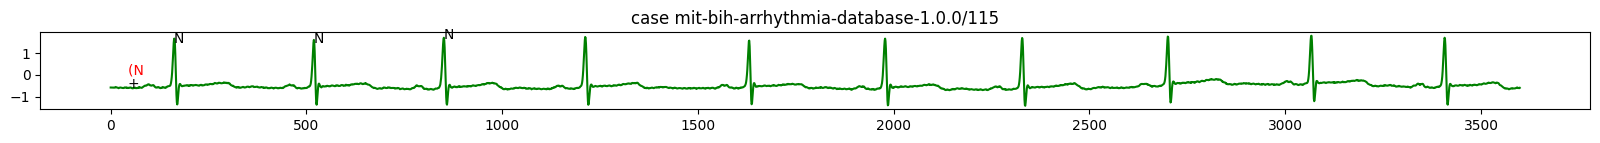

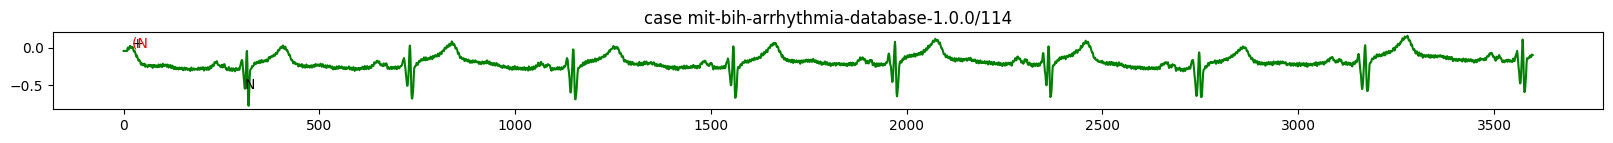

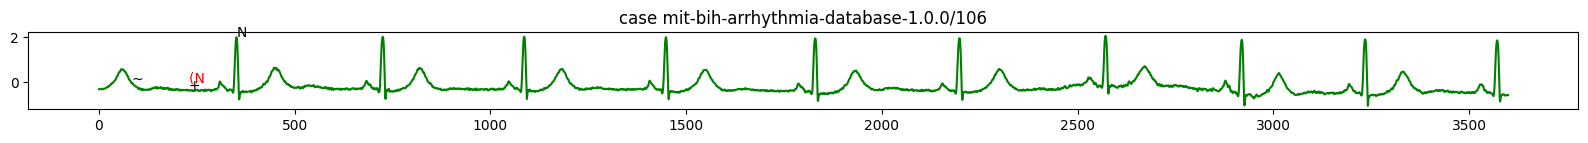

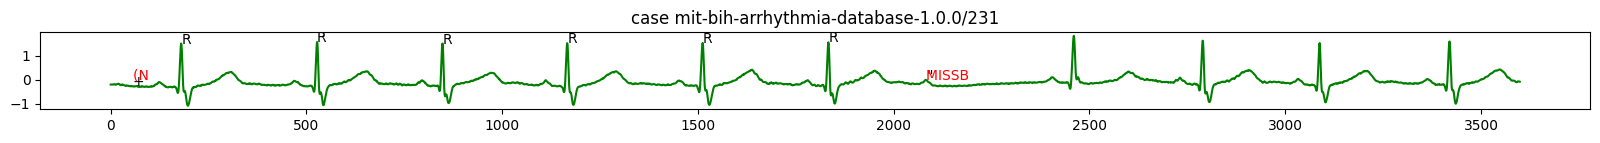

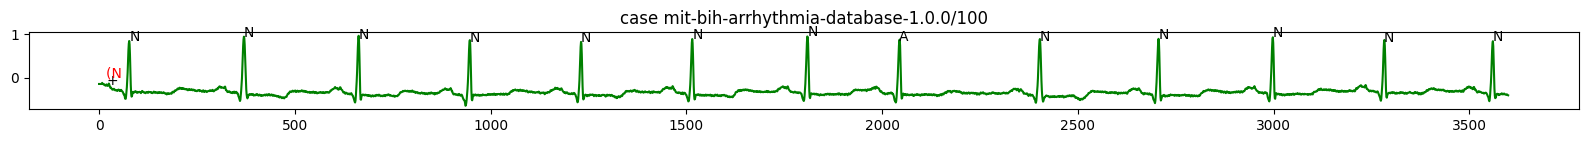

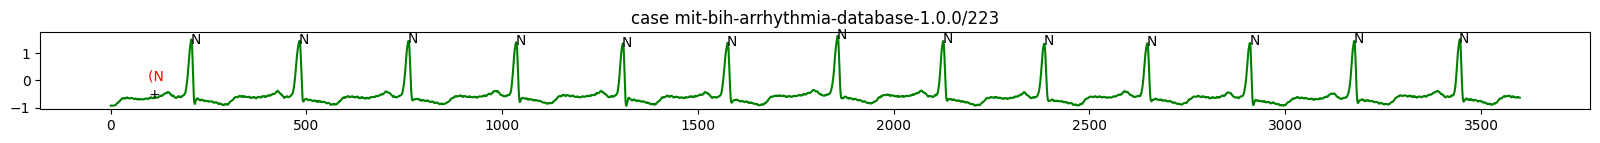

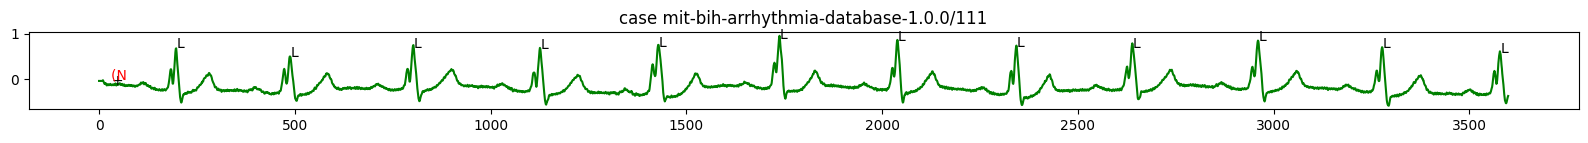

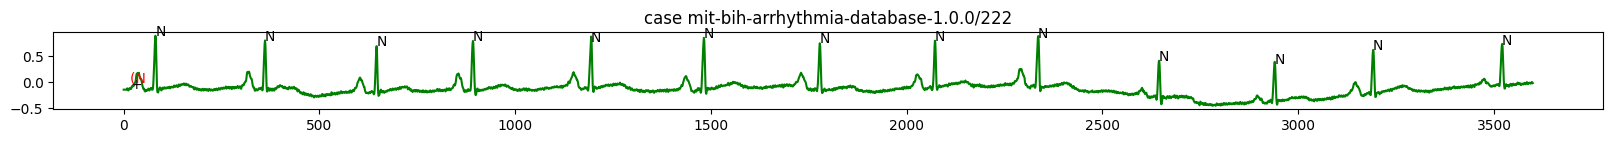

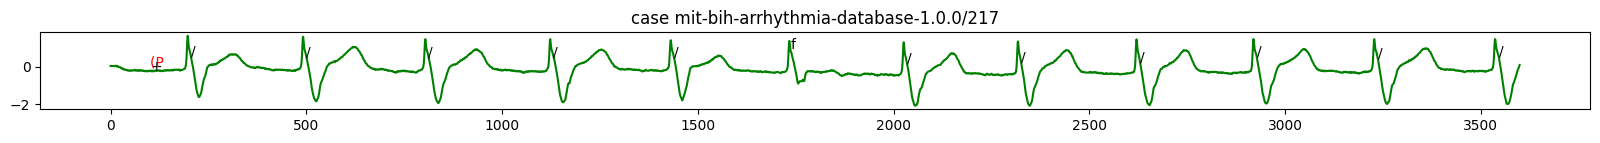

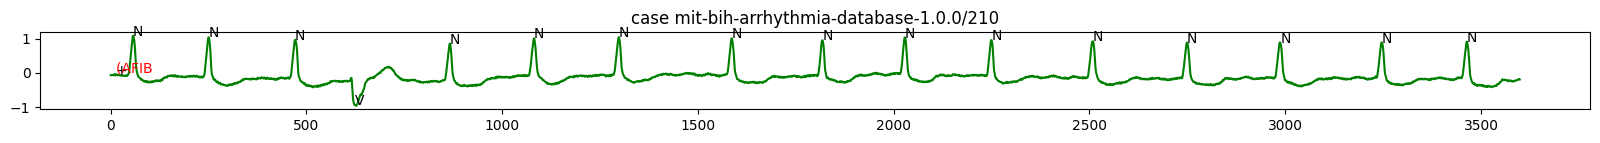

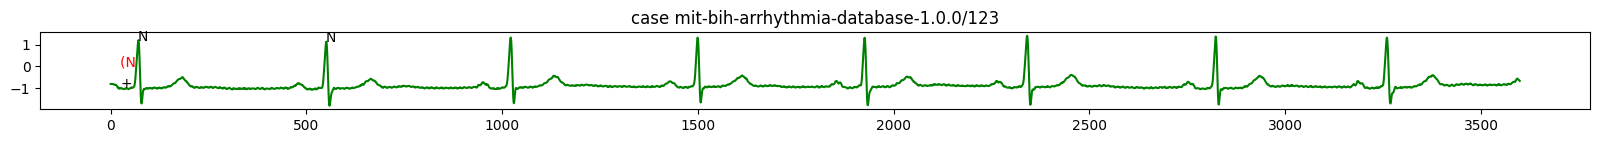

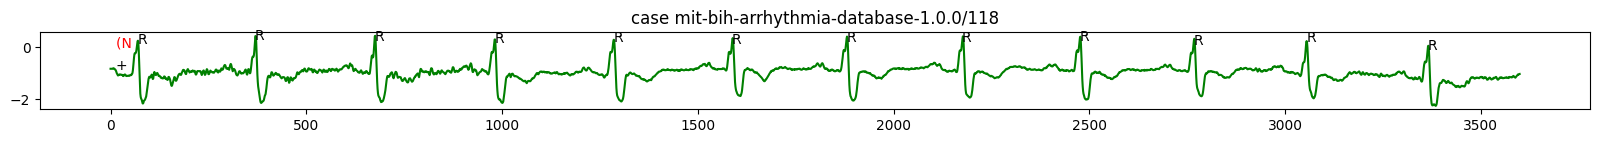

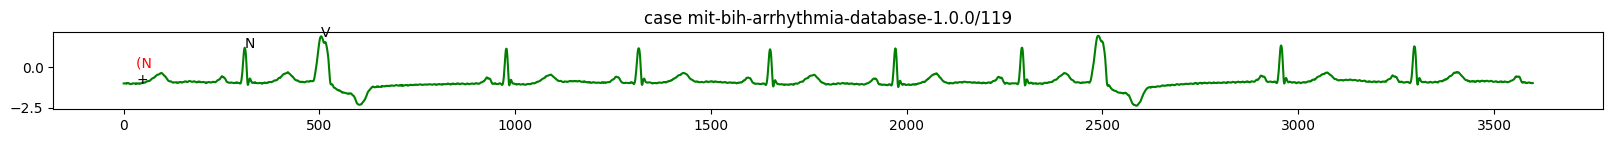

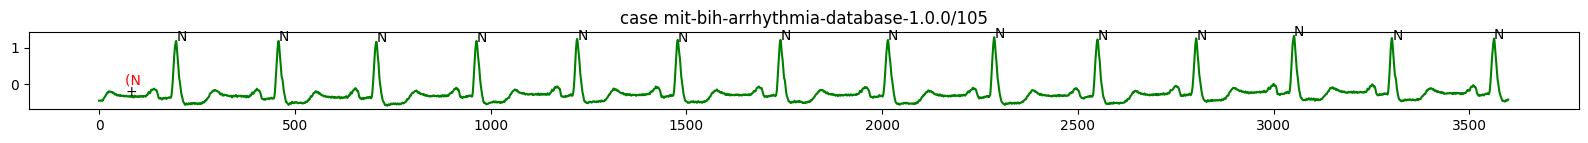

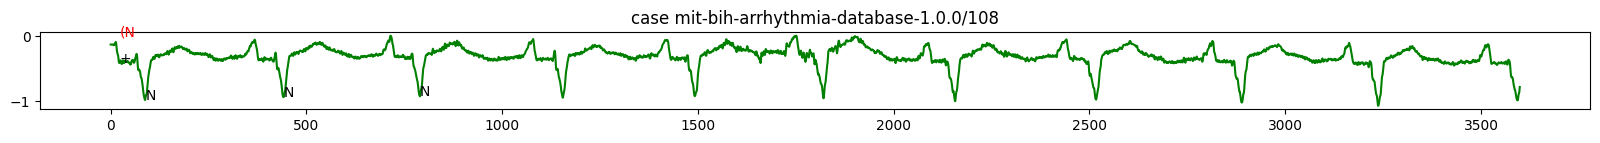

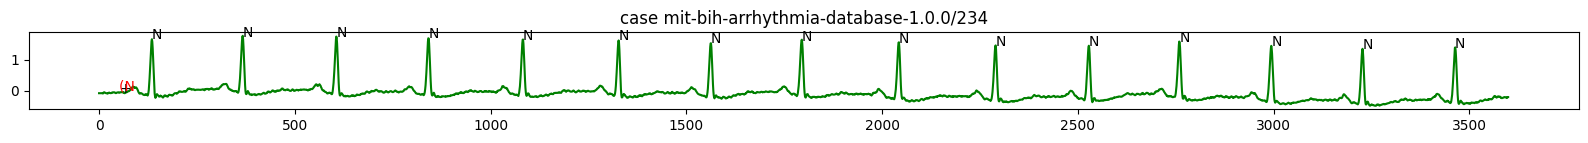

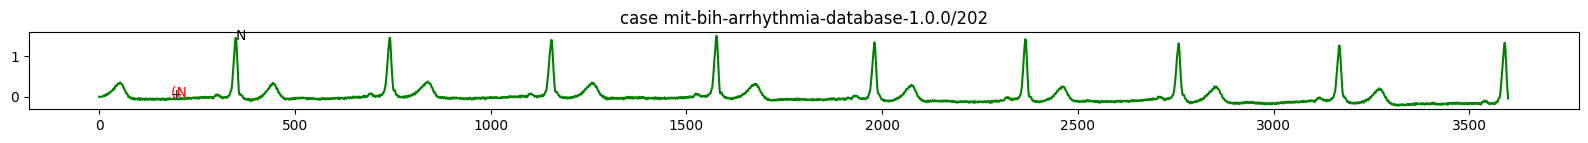

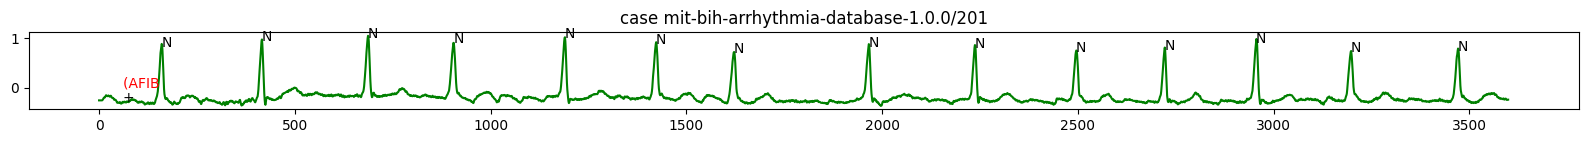

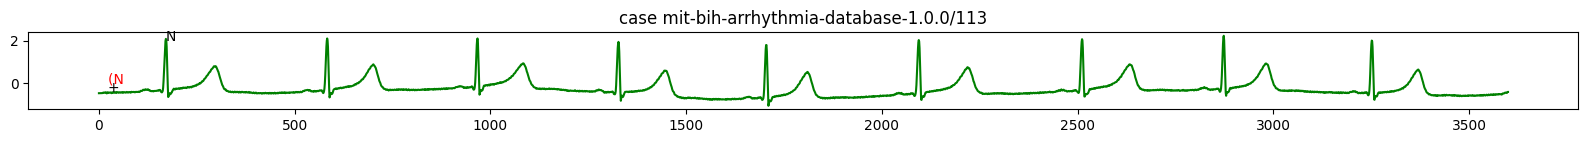

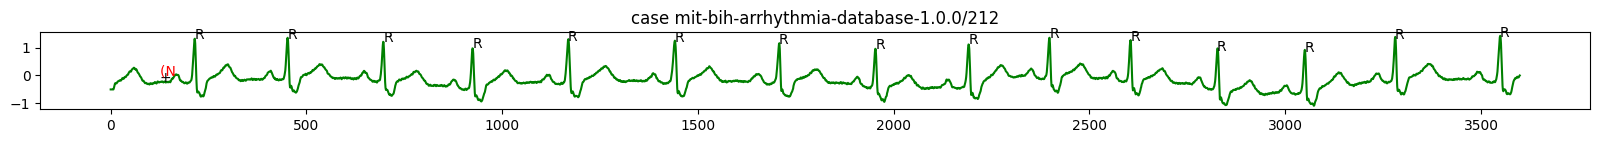

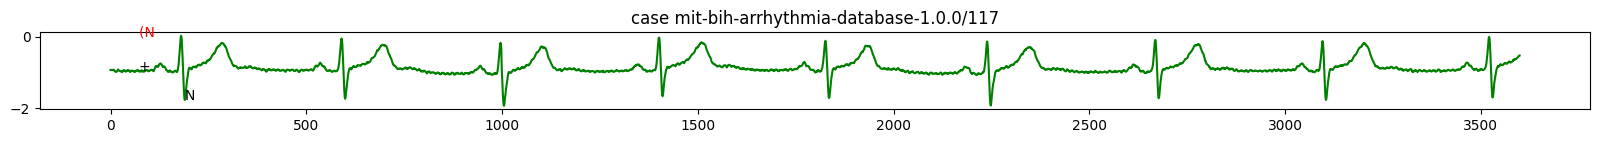

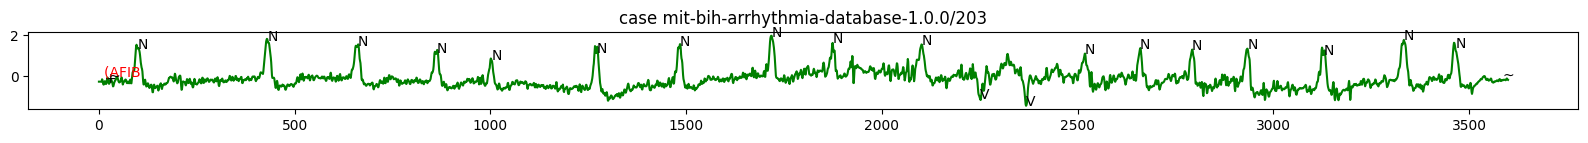

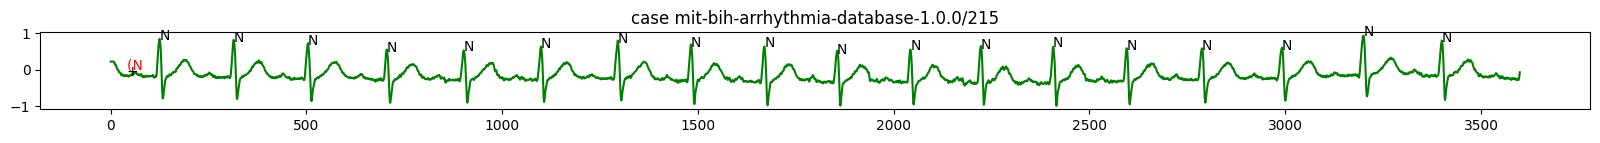

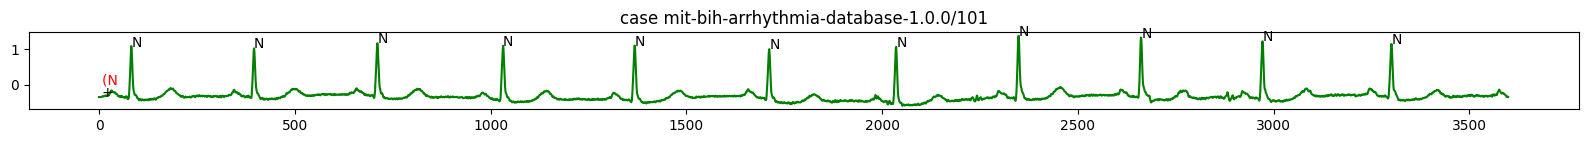

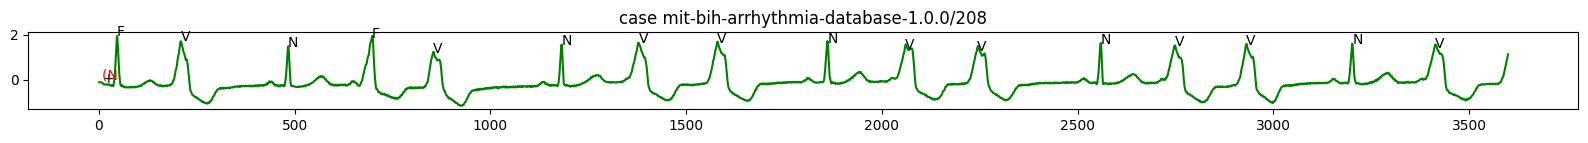

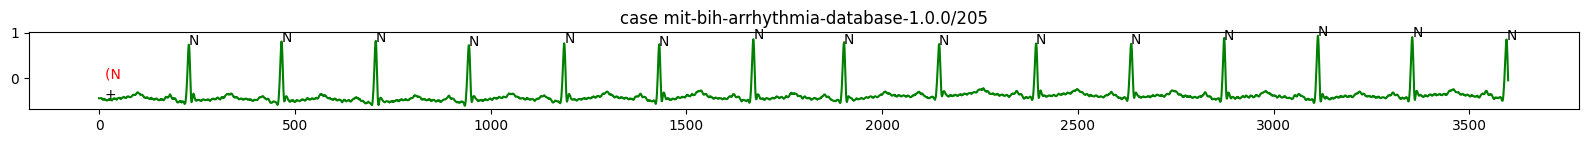

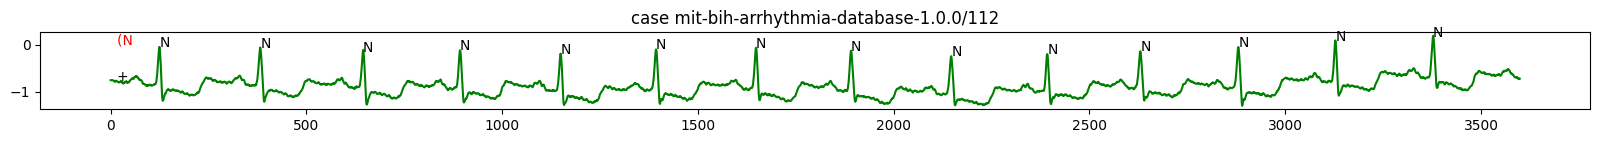

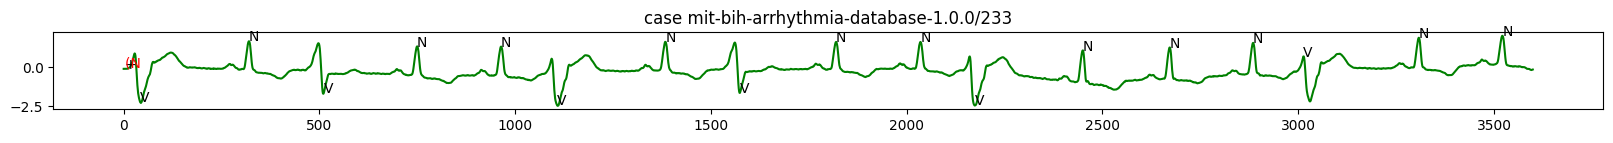

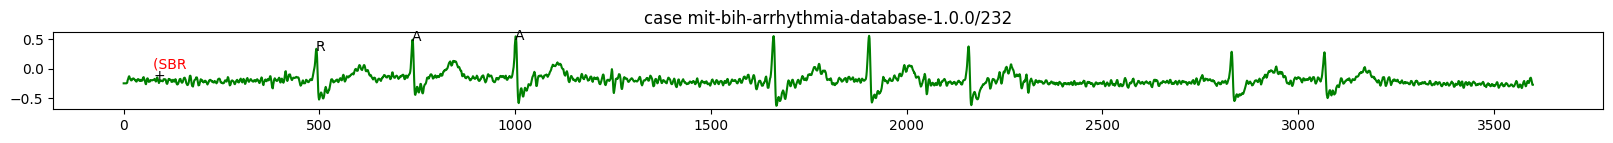

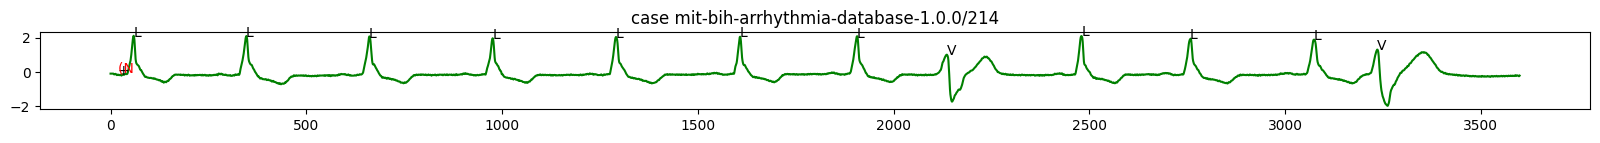

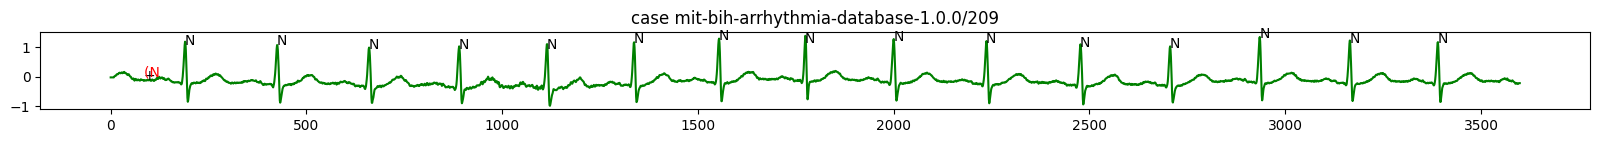

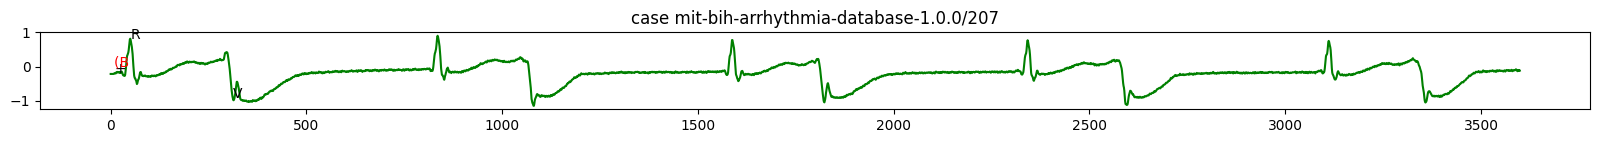

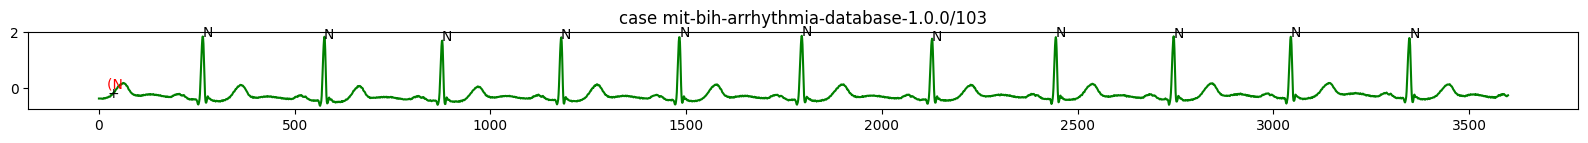

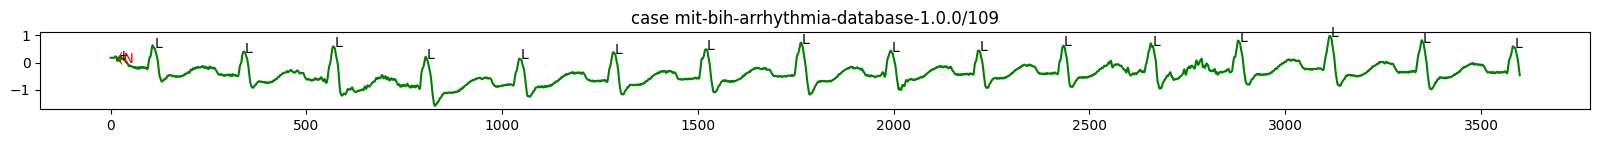

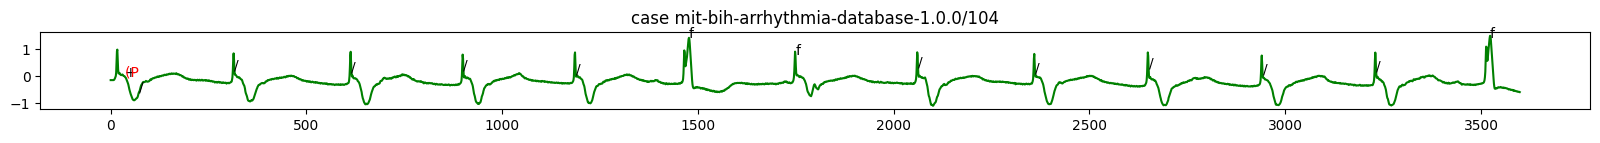

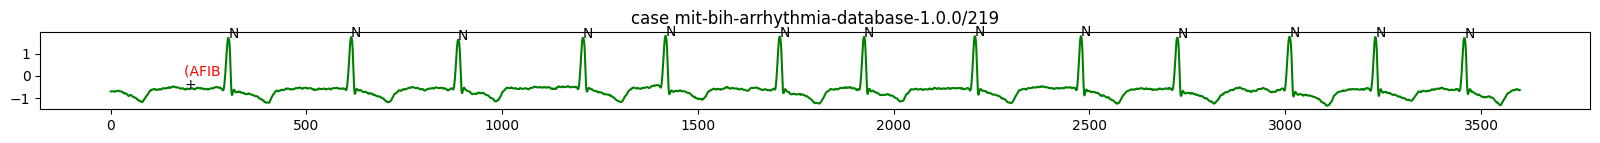

beat_type
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: count, dtype: int64
rhythm_type
         110919
(N          530
MISSB       428
(B          221
(AFIB       107
(PREX       103
(T           83
(VT          61
(P           60
(AFL         45
(NOD         36
(SVTA        26
TS            6
(VFL          6
(BII          5
(IVR          4
(AB           3
PSE           3
(SBR          1
Name: count, dtype: int64


In [16]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SRATE = 360
IPEAK = int(SRATE * 0.3) # PR interval greater than 300 ms is ignored
MAX_BEAT_LEN = int(SRATE * 1) # HR < 12 is ignored
IDIR = 'mit-bih-arrhythmia-database-1.0.0'
DRAW_MAX = SRATE * 10  # 10sec

# Initialize lists to save data statistics
beat_types = []
beat_cnts = []
rhythm_types = []
rhythm_cnts = []
all_beat_samples = []
all_beat_types = []

# Iterate files and load data
for f in os.scandir(IDIR):
    prefix, ext = os.path.splitext(f.path)
    if ext != '.hea':  # each case must have a header
        continue

    # Load sample -> sig_name, p_signal
    samples = wfdb.rdrecord(prefix)

    # Load annotation -> symbol (beat labeling), sample, aux_note (rhythm labeling)
    labels = wfdb.rdann(prefix, 'atr')

    # Update stats
    symbols, cnts = np.unique(labels.symbol, return_counts=True)
    beat_types.extend(symbols)
    beat_cnts.extend(cnts)

    symbols, cnts = np.unique(labels.aux_note, return_counts=True)
    rhythm_types.extend(symbols)
    rhythm_cnts.extend(cnts)

    # Figure
    plt.figure(figsize=(20, 1))
    plt.plot(samples.p_signal[:DRAW_MAX, 0], color='g')
    plt.title(f'case {prefix}')
    lastx = 0
    last_beat_type = ''
    for i in range(len(labels.sample)): # for each label
        x = labels.sample[i]
        y = samples.p_signal[x, 0]

        if labels.chan[i] != 0:
            continue

        beat_type = labels.symbol[i].replace('\x00',' ')
        rhythm_type = labels.aux_note[i].replace('\x00',' ')

        # extract beat samples and type
        if x >= IPEAK:
            if lastx >= IPEAK:
                beat_samples = samples.p_signal[lastx - IPEAK:x - IPEAK, 0]
                if len(beat_samples) > MAX_BEAT_LEN:
                    continue
                # zero pad
                beat_samples = np.pad(beat_samples, (0, MAX_BEAT_LEN - len(beat_samples)))
                all_beat_samples.append(beat_samples)
                all_beat_types.append(last_beat_type)
            last_beat_type = beat_type
            lastx = x

        if x >= DRAW_MAX:
            continue

        plt.text(x, y, beat_type)
        plt.text(x, 0, rhythm_type, color='r')
    plt.show()

# Print the stats
df_beats = pd.DataFrame({'beat_type':beat_types, 'count':beat_cnts})
df_rhythms = pd.DataFrame({'rhythm_type':rhythm_types, 'count':rhythm_cnts})
print(df_beats.groupby('beat_type')['count'].sum().sort_values(ascending=False))
print(df_rhythms.groupby('rhythm_type')['count'].sum().sort_values(ascending=False))


##Beat classification

In [17]:
# beat samples and labels
x = np.array(all_beat_samples)
y = np.array(all_beat_types)

# 3 classes
LABEL_BEATS = {'N': ( # non-ectopic beat
                    'N', # normal beat
                    'L', # left bundle branch block beat
                    'R', # right bundle branch block beat
                    'e', # atrial escape beat (occurs after a long pause in the normal heart rhythm, essentially acting as a backup beat when the sinus node fails to fire)
                    'A', # atrial premature beat (originates in the atrium and happens earlier than expected in the normal rhythm, essentially interrupting the regular beat)
                    'a', # aberrated atrial premature beat
                ), 'S': ( # supra-ventricular ectopic beat
                    'S',  # supraventricular premature beat
                    'j', # junctional escape beat
                    # 'x', # non-conducted P-wave (blocked APB)
                    'J', # junctional premature beat
                ), 'V': ( # ventricular ectopic beats
                    'V', # premature ventricular contraction
                    # '!', # ventricular flutter wave
                    'E', # ventricular escape beat
                # ), 'F': ( # fusion of ventricular and normal beat
                #     'F', # fusion of ventricular and normal beat
                # ), 'Q': (  # unclassified
                #     'Q', # unclassified -> unclassified beats that are not used for training and validation
                #     '/', # paced beat
                #     'f' # fusion of paced and normal beat
                )}  # 5-class

# one hot encode
labels = list(LABEL_BEATS.keys())
o = np.zeros((len(y), len(labels)), dtype=bool)
for i in range(len(labels)):
    o[:, i] = np.isin(y, LABEL_BEATS[labels[i]])

# min-max normalization
x -= x.min(axis=1)[...,None]
x /= x.max(axis=1)[...,None]
x = x[...,None]  # add dimension for cnn

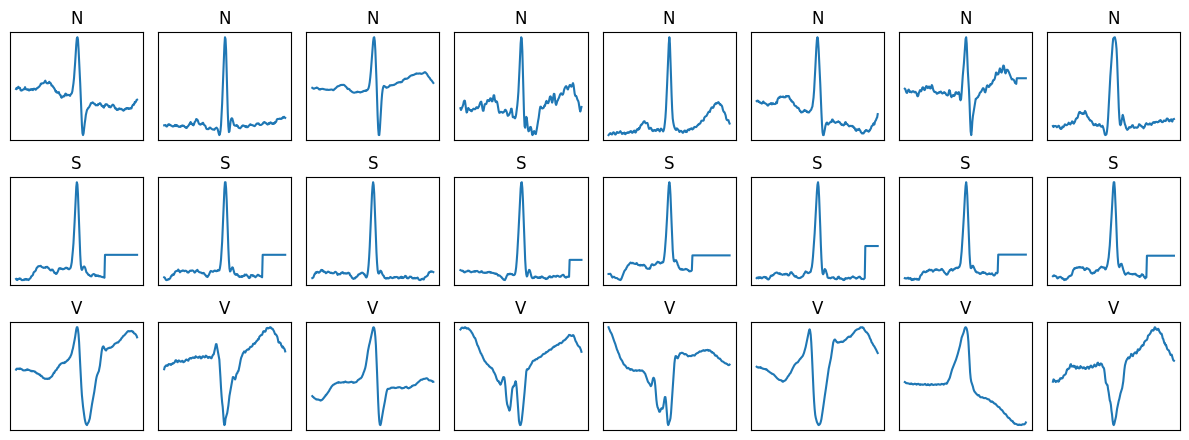

In [18]:
import random

SAMPLES_PER_LABEL = 8  # Number of samples to select per label

# Plot the sampled data
fig, axes = plt.subplots(len(labels), SAMPLES_PER_LABEL, figsize=(1.5 * SAMPLES_PER_LABEL, 1.5 * len(labels)))
for i, label in enumerate(labels):
    # Randomly sample indices
    sampled_indices = random.sample(np.where(o[:, i])[0].tolist(), SAMPLES_PER_LABEL)
    for j in range(SAMPLES_PER_LABEL):
        ax = axes[i,j]
        ax.plot(x[sampled_indices[j],:IPEAK*2])
        ax.set_title(label)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
import keras.models
from keras.models import Model
from keras.layers import Layer, LayerNormalization, BatchNormalization, Activation, Dense, TimeDistributed, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Add, Input, Concatenate, MultiHeadAttention, Flatten, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score, accuracy_score, log_loss, classification_report

# hyperparameters
clayer = 3
nfilt = 32
filtsize = 11
flayer = 1
fnode = 256
droprate = 0.2

# common input
inp = Input(shape=x.shape[1:])
out = inp
for ilayer in range(clayer):
    out = Conv1D(nfilt, filtsize, padding='same', activation='relu', kernel_initializer='he_normal')(out)
    out = MaxPooling1D(2, padding='same')(out)
for i in range(flayer):
    out = Dense(fnode, activation='relu')(out)
    out = Dropout(droprate)(out)
#out = GlobalAveragePooling1D()(out)
out = Flatten()(out)
out = Dense(o.shape[1], activation='softmax')(out)

model = Model(inputs=[inp], outputs=[out])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_test, o_train, o_test = train_test_split(x, o, test_size=0.3)

# train a model
cache_path = "model.keras"
hist = model.fit(x_train, o_train, epochs=100, batch_size=256,
            validation_split=0.2,
            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=cache_path, verbose=1, save_best_only=True),
                        EarlyStopping(monitor='val_loss', patience=1, mode='auto')])
model.load_weights(cache_path)  # reload the best model

# make prediction
p_test = np.argmax(model.predict(x_test), axis=1)
test_acc = accuracy_score(np.argmax(o_test, axis=1), p_test) * 100
print(f'test accuracy={test_acc:.3f} %')

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 360, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 360, 32)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 180, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 180, 32)             │          11,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 90, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 90, 32)              │          11,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 45, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 45, 256)             │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 45, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │          34,563 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,987 (257.76 KB)

 Trainable params: 65,987 (257.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8501 - loss: 22.3499
Epoch 1: val_loss improved from inf to 1941.50183, saving model to model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8500 - loss: 23.8438 - val_accuracy: 0.9593 - val_loss: 1941.5018
Epoch 2/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8235 - loss: 8571.3760
Epoch 2: val_loss did not improve from 1941.50183
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8233 - loss: 9102.0723 - val_accuracy: 0.3309 - val_loss: 179108.1406
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
test accuracy=95.524 %


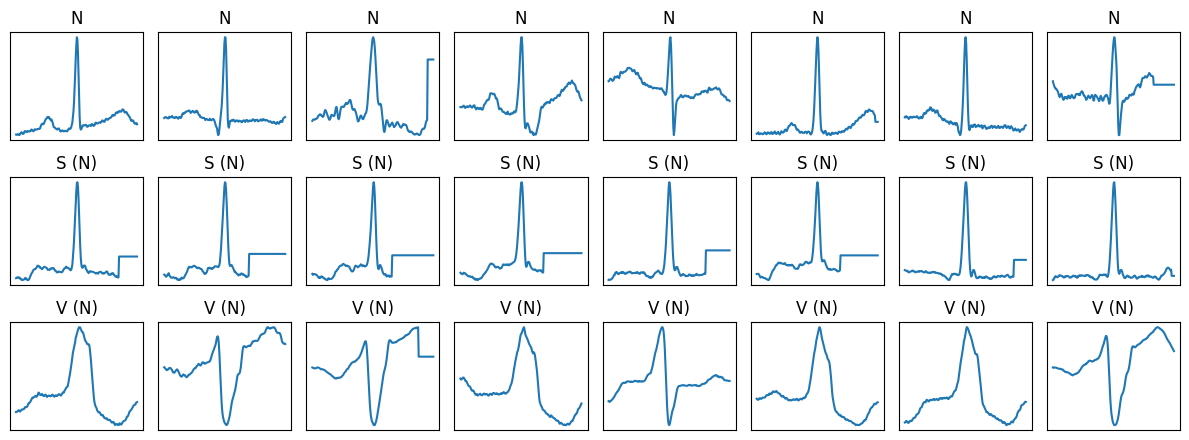

In [20]:
# Plot the sampled data
fig, axes = plt.subplots(len(labels), SAMPLES_PER_LABEL, figsize=(1.5 * SAMPLES_PER_LABEL, 1.5 * len(labels)))
for i, label in enumerate(labels):  # N, S, V
    # Randomly sample indices
    sampled_indices = random.sample(np.where(o_test[:, i])[0].tolist(), SAMPLES_PER_LABEL)
    for j in range(SAMPLES_PER_LABEL):
        ax = axes[i,j]
        ax.plot(x_test[sampled_indices[j],:IPEAK*2])
        pred = labels[p_test[sampled_indices[j]]]
        if label == pred:
            ax.set_title(f'{label}')
        else:
            ax.set_title(f'{label} ({pred})')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()